In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
model = tf.keras.models.load_model('./model/resnetV2.h5')
print('Model Loaded')

Model Loaded


In [3]:
path = 'C:/MyProjects/NumberPlate_OCR/data/c13.jpg'
image = load_img(path)
image = np.array(image, dtype=np.uint8)
image1 = load_img(path, target_size=(224, 224))
image_arr = img_to_array(image1) / 255.0

In [4]:
h, w, d = image.shape
print('Height: ', h)
print('Width: ',w)

Height:  232
Width:  500


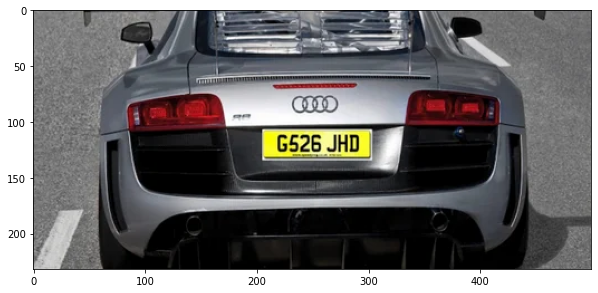

In [5]:
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.show()

In [6]:
image_arr.shape

(224, 224, 3)

In [7]:
# 1 indicates the number of images passed
test_arr = image_arr.reshape(1, 224, 224, 3)
test_arr.shape

(1, 224, 224, 3)

In [8]:
coords = model.predict(test_arr)
coords

1/1 [==============================] - 2s 2s/step


array([[0.37742996, 0.6420526 , 0.45358628, 0.60799325]], dtype=float32)

### Denormalizing the coordinates

In [9]:
denorm = np.array([w, w, h, h])
coords = coords * denorm
coords

array([[188.71498108, 321.02629542, 105.23201704, 141.05443287]])

In [10]:
coords = coords.astype(np.int32)
coords

array([[188, 321, 105, 141]])

In [11]:
xmin, xmax, ymin, ymax = coords[0]
pt1 = (xmin, ymin)
pt2 = (xmax, ymax)
print(pt1, pt2)

(188, 105) (321, 141)


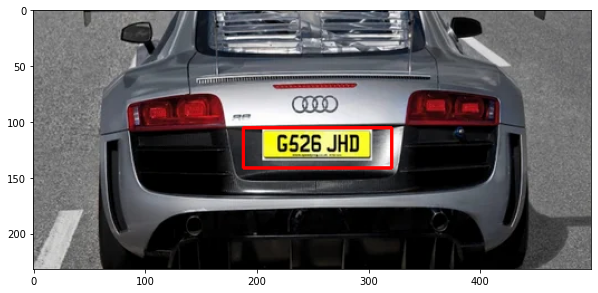

In [12]:
cv2.rectangle(image, pt1, pt2, (255, 0, 0), 2)
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.show()

### Creating Pipeline for prediction

In [13]:
path = ''
def detect(path):
    image = load_img(path)
    image = np.array(image, dtype=np.uint8)
    image1 = load_img(path, target_size=(224, 224))
    image_arr = img_to_array(image1) / 255.0
    h, w, d = image.shape
    test_arr = image_arr.reshape(1, 224, 224, 3)

    coords = model.predict(test_arr)

    denorm = np.array([w, w, h, h])
    coords = coords * denorm
    coords = coords.astype(np.int32) 

    xmin, xmax, ymin, ymax = coords[0]
    pt1 = (xmin, ymin)
    pt2 = (xmax, ymax)

    cv2.rectangle(image, pt1, pt2, (255, 0, 0), 3)
    return image, coords

In [14]:
def detect_in_image(image):
    #image = load_img(path)
    image1 = cv2.resize(image, (224, 224))
    image = np.array(image, dtype=np.uint8)
    #image1 = load_img(path, target_size=(224, 224))
    
    image_arr = img_to_array(image1) / 255.0
    h, w, d = image.shape
    test_arr = image_arr.reshape(1, 224, 224, 3)

    coords = model.predict(test_arr)

    denorm = np.array([w, w, h, h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    xmin, xmax, ymin, ymax = coords[0]
    pt1 = (xmin, ymin)
    pt2 = (xmax, ymax)

    cv2.rectangle(image, pt1, pt2, (255, 0, 0), 3)
    return image, coords

1/1 [==============================] - 0s 108ms/step


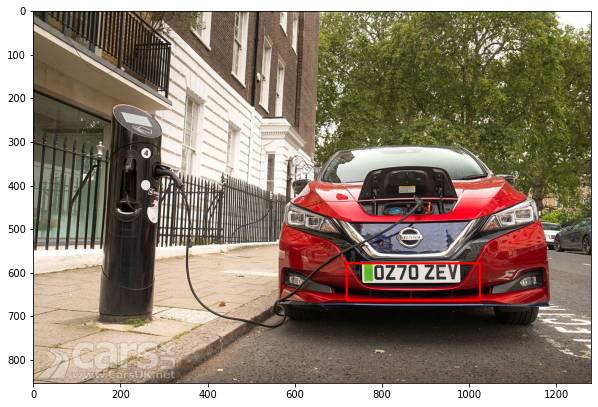

In [15]:
path = 'C:/MyProjects/NumberPlate_OCR/data/c25.jpg'
image, cd = detect(path)

plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.show()

### Using EasyOCR to extract text from plates.

In [ ]:
!pip install easyocr

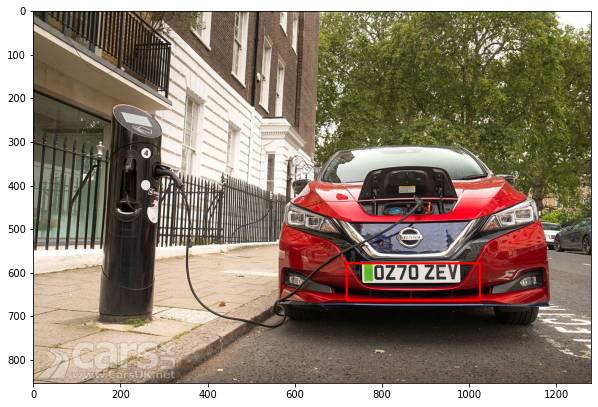

In [17]:
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.show()

In [18]:
xmin, xmax, ymin, ymax = cd[0][0], cd[0][1], cd[0][2], cd[0][3]

In [19]:
cropped_img = image[ymin:ymax, xmin:xmax]

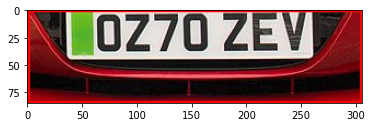

In [20]:
plt.imshow(cropped_img)

In [21]:
reader = easyocr.Reader(['en'])
results = reader.readtext(cropped_img)
if results:
    detected_text = results[0][1] 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [22]:
detected_text

'0z70 ZEV'

### Using webcam to detect image and performing OCR

In [24]:
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    img, coords = detect_in_image(frame)
    xmin, xmax, ymin, ymax = coords[0][0], coords[0][1], coords[0][2], coords[0][3]
    results = reader.readtext(frame[ymin:ymax, xmin:xmax])
    
    if results:
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
        cv2.putText(frame, results[0][1], (xmin + 5, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 3)
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 101ms/step


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
